NOTE: two head stochastic regressor was taken from https://github.com/mvaldenegro/keras-uncertainty/blob/master/keras_uncertainty/models/stochastic_model.py and adjusted for our task.

In [ ]:
import numpy as np
import torch

lower_trs = -15
higher_trs = 15

def f(x):
    return x * np.sin(x)

x_range = np.linspace(lower_trs, higher_trs, 100)
y_true = f(x_range)
x_range1 = np.linspace(lower_trs-10, higher_trs+10, 200)
y_true1 = f(x_range1)

np.random.seed(42)

# TEST SET
n_training_samples = 15000
x_test = np.random.uniform(low=lower_trs, high=higher_trs, size=n_training_samples)
y_test = f(x_test) + np.random.normal(loc=0.0, scale=0.21, size=n_training_samples) + np.random.normal(loc=0.0, scale=0.37, size=n_training_samples) * x_test

x_test = torch.tensor(x_test).view(-1, 1)
y_test = torch.tensor(y_test).view(-1, 1)

# TRAIN SET
x_train = []
y_train = []
for i in range(len(x_test)):
  if x_test[i] > -10 and x_test[i] < 10:
    x_train.append(x_test[i])
    y_train.append(y_test[i])

x_train = torch.tensor(x_train).view(-1, 1)
y_train = torch.tensor(y_train).view(-1, 1)

# Create TensorDataset with normalized data
dataset = TensorDataset(x_train, y_train)


NameError: name 'TensorDataset' is not defined

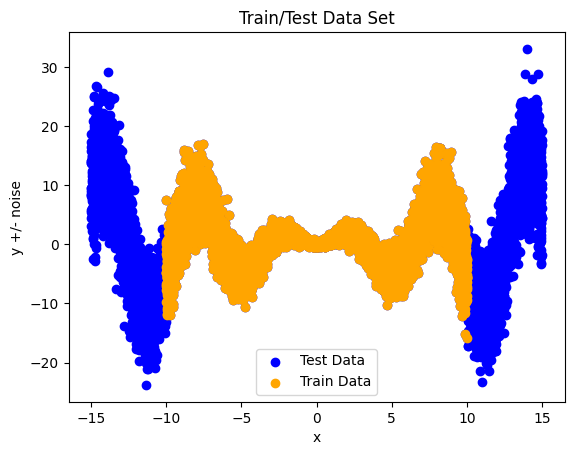

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(x_test, y_test, color='blue', label='Test Data')
plt.scatter(x_train, y_train, color='orange', label='Train Data')

plt.title('Train/Test Data Set')
plt.xlabel('x')
plt.ylabel('y +/- noise')
plt.legend()
plt.show()

In [ ]:
import torch.nn as nn

class Network(nn.Module):
  def __init__(self):
    super(Network, self).__init__()
    self.layers = nn.Sequential(
      torch.nn.Linear(1, 8),
      torch.nn.ReLU(),
      torch.nn.Dropout(0.1),
      torch.nn.Linear(8,16),
      torch.nn.ReLU(),
      torch.nn.Dropout(0.1),
      torch.nn.Linear(16,32),
      torch.nn.ReLU(),
      torch.nn.Dropout(0.1),
      torch.nn.Linear(32,16),
      torch.nn.ReLU(),
      torch.nn.Linear(16,4),
      torch.nn.ReLU(),
    )
    self.mean_head = torch.nn.Linear(4, 1)
    self.var_head = nn.Sequential(
        torch.nn.Linear(4, 1),
        torch.nn.ReLU(),
        )

    self.double()

  def forward(self, x):
    features = self.layers(x)
    mean = self.mean_head(features)
    variance = self.var_head(features)
    return mean, variance

  def predict(self, x):
    mean, variance = self(x)
    return mean, variance

class TwoHeadStochasticRegressor:
    def __init__(self, model, num_samples=100, variance_type="linear_variance"):
        self.model = model
        self.num_samples = num_samples
        assert variance_type in ["logit", "linear_std", "linear_variance"]
        self.variance_type = variance_type

    """
        Preprocesses and interprets the variance output prodcued by the model, producing a standard deviation.
    """
    def preprocess_variance_output(self, var_input):
        if self.variance_type == "logit":
            return np.exp(var_input)

        if self.variance_type == "linear_variance":
            return np.sqrt(var_input)

        return var_input

    def predict_samples(self, x, num_samples=None, batch_size=32, multi_output=False, **kwargs):
        """
            Performs num_samples predictions using the model, and returns the produced output samples.
        """

        if num_samples is None:
            num_samples = self.num_samples

        assert num_samples > 0
        samples = [None] * num_samples

        if "verbose" not in kwargs:
            kwargs["verbose"] = 0

        self.model.train()
        with torch.no_grad():
            for i in range(num_samples):
                samples[i] = self.model.predict(x)

        self.model.eval()

        if multi_output:
            return samples
        else:
            return np.array(samples)

    def predict(self, inp, num_samples=100, batch_size=32, output_scaler=None, disentangle_uncertainty=False, output_aleatoric_epi=False, **kwargs):
        """
            Performs a prediction given input inp and returns the mean and standard deviation of the model output.
        """
        samples = self.predict_samples(inp, num_samples, batch_size=batch_size, multi_output=True, **kwargs)
        mean_samples, var_samples = [x[0] for x in samples], [x[1] for x in samples]

        if output_scaler is not None:
            mean_samples = list(map(lambda x: output_scaler.inverse_transform(x), mean_samples))
            var_samples = list(map(lambda x: output_scaler.inverse_transform(x), var_samples))

        means = np.array([x.detach().numpy() for x in mean_samples])
        variances = np.array([x.detach().numpy() for x in var_samples])
        stds = self.preprocess_variance_output(variances)

        mixture_mean = np.mean(means, axis=0)
        mixture_var = np.mean(np.square(stds) + np.square(means), axis=0) - np.square(mixture_mean)
        mixture_var[mixture_var < 0.0] = 0.0
        mixture_std = np.sqrt(mixture_var)

        if disentangle_uncertainty:
            epi_std = np.std(means, axis=0)
            ale_std = np.mean(stds, axis=0)

            if output_aleatoric_epi:
                ale_std_epi = np.std(stds, axis=0)

                return mixture_mean, ale_std, epi_std, ale_std_epi

            return mixture_mean, ale_std, epi_std

        return mixture_mean, mixture_std

In [ ]:
from torch.utils.data import DataLoader, TensorDataset

EPOCH_NUMBER = 100

device = "cpu"
x_train_tensor = torch.tensor(x_train, dtype=torch.double)
y_train_tensor = torch.tensor(y_train, dtype=torch.double)


dataset = TensorDataset(x_train_tensor, y_train_tensor)

# Create a DataLoader to iterate over batches of data
batch_size = 8
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

model = Network()
loss_function = torch.nn.GaussianNLLLoss()

optimizer = torch.optim.Adam(model.parameters(), lr= 0.0001)
loss_values = []
previous_loss = 0
counter = 3

for epoch in range(EPOCH_NUMBER):
      epoch_loss = 0
      for batch_x, batch_y in dataloader:
        optimizer.zero_grad()

        # Forward pass
        batch_prediction, batch_variance = model(batch_x)

        # Compute loss
        loss = loss_function(batch_prediction, batch_y, batch_variance)



        epoch_loss += loss.item()

        # Backward pass
        loss.backward()

        # Update parameters
        optimizer.step()

      print(epoch_loss)
      #print(np.divide(epoch_loss,len(x_train)/8))
      loss_values.append(epoch_loss)

      if epoch_loss > previous_loss:
        print("not decreasing, n tries left", counter)
        counter -= 1
      else:
        counter = 3
      if counter == 0:
          print("training done, too much bad")
          break
      previous_loss = epoch_loss


print("Training completed")

<ipython-input-27-ee5099f5c17f>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train_tensor = torch.tensor(x_train, dtype=torch.double)
<ipython-input-27-ee5099f5c17f>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train, dtype=torch.double)


15671.15768408898
not decreasing, n tries left 3
3751.5332326759703
2542.1964574203016
2348.2765590017807
2286.8343632273018
2259.8853519306554
2237.9010317050715
2205.9098521522633
2184.3471452472354
2156.9229473809496
2114.7777636919477
2079.413627176521
2049.032719597462
2041.7921266670212
2025.9020544738546
2003.6963498352552
2002.120984942503
1994.5290894527102
2001.262429188538
not decreasing, n tries left 3
1981.672715076887
1973.6189990465475
1965.1608851440408
1950.5577921099102
1935.4454867019351
1925.6298015019288
1914.0100836285442
1902.5505670166474
1878.6217276019177
1881.277643917817
not decreasing, n tries left 3
1861.0883545385232
1850.9719056774666
1849.6834556554081
1823.297809749247
1821.2465382419575
1806.001742317074
1797.3161206666693
1793.6002205404855
1774.0794287605288
1767.833078160304
1759.2732432077416
1753.6853484830572
1756.5522339076422
not decreasing, n tries left 3
1738.3059446416755
1733.4080950452721
1729.0068642096358
1733.0596673470727
not decreasi

Text(0, 0.5, 'Average loss per epoch')

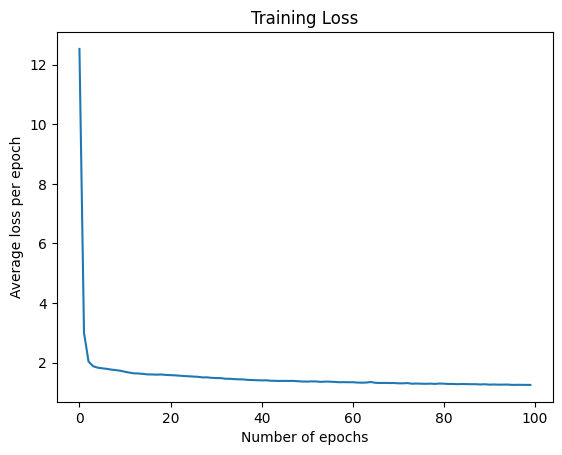

In [ ]:
plt.plot(np.divide(loss_values,len(x_train)/8))
plt.title('Training Loss')
plt.xlabel('Number of epochs')
plt.ylabel('Average loss per epoch')

[13.52572427 12.85103883 12.61407532 ... 13.88530245 14.65169753
 13.71057938]


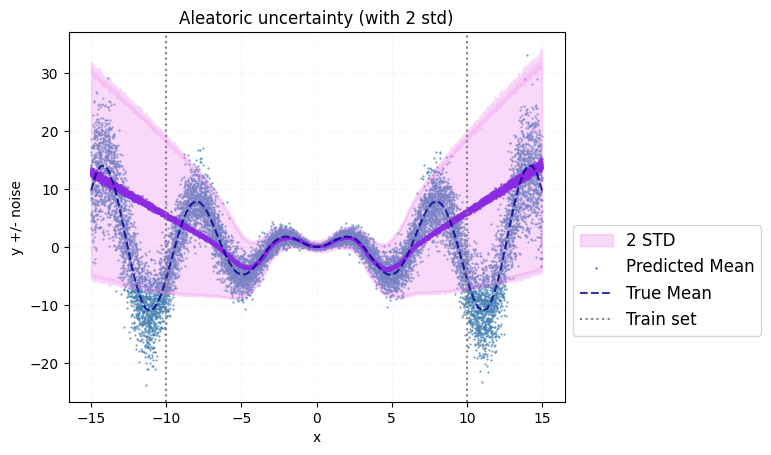

In [ ]:
from torch.distributions import Normal
import math

#potentially set to 20
stochastic_regressor = TwoHeadStochasticRegressor(model, num_samples=100, variance_type="linear_variance")

mean_predict_test, ale_std_test, epi_std_test = stochastic_regressor.predict(x_test, disentangle_uncertainty=True)
# mean_predict_test = mean_predict_test.detach().numpy()
# std_predict_test = std_predict_test.detach().numpy()
x_test_flattenned = x_test.flatten()
std_predict_test = ale_std_test

sorted_indices_test = np.argsort(x_test_flattenned)

x_test_sorted = x_test[sorted_indices_test].flatten()
y_test_sorted = y_test[sorted_indices_test]

mean_predict_flattened = mean_predict_test[sorted_indices_test].flatten()
std_predict_flattened = std_predict_test[sorted_indices_test].flatten()

print(mean_predict_flattened)

plt.scatter(x_test, y_test, color ='steelblue', s = 0.2)
plt.fill_between(x_test_sorted, mean_predict_flattened - 2 * std_predict_flattened, mean_predict_flattened + 2 * std_predict_flattened, color='violet', alpha=0.3, label='2 STD')
plt.scatter(x_test_sorted, mean_predict_flattened, s = 1, color ='blueviolet', alpha = 0.6, label='Predicted Mean')
plt.plot(x_range, y_true, linestyle='--', color ='darkblue', alpha = 0.8, label='True Mean')

plt.title('Aleatoric uncertainty (with 2 std)')
plt.grid(True, linestyle='--', alpha=0.1, color = "violet")


plt.axvline(x=10, color='grey', linestyle='dotted', label = "Train set")
plt.axvline(x=-10, color='grey', linestyle='dotted')

plt.xlabel('x')
plt.ylabel('y +/- noise')

plt.legend(loc='upper left', bbox_to_anchor=(1, 0.5), fontsize=12)

plt.show()

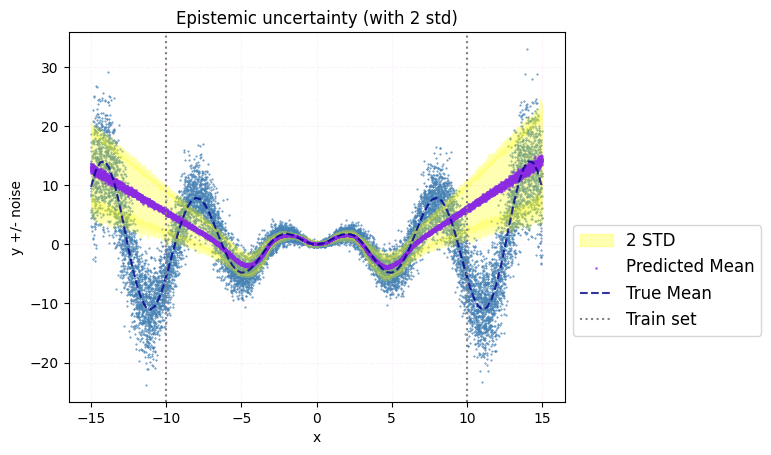

In [ ]:
x_test_flattenned = x_test.flatten()
std_predict_test = epi_std_test

sorted_indices_test = np.argsort(x_test_flattenned)

x_test_sorted = x_test[sorted_indices_test].flatten()
y_test_sorted = y_test[sorted_indices_test]

mean_predict_flattened = mean_predict_test[sorted_indices_test].flatten()
std_predict_flattened = std_predict_test[sorted_indices_test].flatten()

plt.scatter(x_test, y_test, color ='steelblue', s = 0.2)
plt.fill_between(x_test_sorted, mean_predict_flattened - 2 * std_predict_flattened, mean_predict_flattened + 2 * std_predict_flattened, color='yellow', alpha=0.3, label='2 STD')
plt.scatter(x_test_sorted, mean_predict_flattened, s = 1, color ='blueviolet', alpha = 0.6, label='Predicted Mean')
plt.plot(x_range, y_true, linestyle='--', color ='darkblue', alpha = 0.8, label='True Mean')

plt.title('Epistemic uncertainty (with 2 std)')
plt.grid(True, linestyle='--', alpha=0.1, color = "violet")


plt.axvline(x=10, color='grey', linestyle='dotted', label = "Train set")
plt.axvline(x=-10, color='grey', linestyle='dotted')

plt.xlabel('x')
plt.ylabel('y +/- noise')

plt.legend(loc='upper left', bbox_to_anchor=(1, 0.5), fontsize=12)
# Display the plot
plt.show()

